In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [178]:
data = pd.read_csv('dataset_reformate2.csv')

data

,pays,date,nombre_total,entree_mensuelle
0,Albania,2014-02-01,1333,16.0
1,Germany,2014-02-01,306716,445.0
2,Andorra,2014-02-01,23,0.0
3,Austria,2014-02-01,41225,-37.0
4,Belarus,2014-02-01,1143,39.0
...,...,...,...,...
25795,Total Oceania,2024-10-01,4010,37.0
25796,Stateless,2024-10-01,1254,985.0
25797,Stateless,2024-10-01,272,-982.0
25798,Unknown,2024-10-01,1089,2.0


In [179]:
pays = 'France'

data['date'] = pd.to_datetime(data['date'])  # Conversion en datetime
#germany_data = data[data['pays'] == pays].sort_values(by='date')
#germany_data

# List of countries to include in the sum
countries = ["Total Europe", "Total Africa", "Total America", "Total Asia", "Total Oceania", "Total Unknown Origin"]
# Filter data for the specified countries
df_countries = data[data['pays'].isin(countries)]
germany_data = df_countries.groupby('date').sum().reset_index()

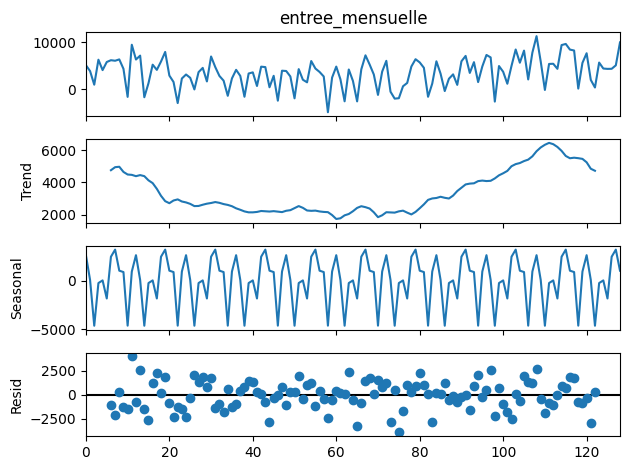

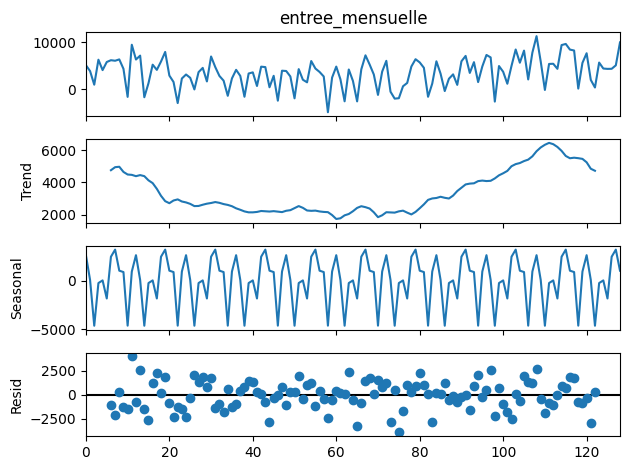

In [180]:
# Paramètres de séquences temporelles
sequence_length = 12 * 2  # Utiliser les 12 derniers mois pour prédire le suivant

# Extraire la variable cible
values = germany_data['entree_mensuelle'].values

# Décomposition saisonnière pour extraire la tendance et la saisonnalité
# On peut utiliser un modèle multiplicatif ou additif selon les données
decomposed = seasonal_decompose(germany_data['entree_mensuelle'], model='additive', period=12)

# Extraire les composants de la décomposition
germany_data['trend'] = decomposed.trend
germany_data['seasonal'] = decomposed.seasonal
germany_data['residual'] = decomposed.resid

# Remplacer les valeurs NaN dans la tendance par 0
germany_data['trend'] = germany_data['trend'].fillna(0)
germany_data['seasonal'] = germany_data['seasonal'].fillna(0)
germany_data['residual'] = germany_data['residual'].fillna(0)

decomposed.plot()

In [181]:
# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalisation des données d'entrée avec les tendances et saisonnalités
scaled_values = scaler.fit_transform(germany_data[['entree_mensuelle', 'trend', 'seasonal', 'residual']])

# Créer les séquences temporelles
X, y = [], []
for i in range(len(scaled_values) - sequence_length):
    X.append(scaled_values[i:i + sequence_length])
    y.append(scaled_values[i + sequence_length][0])  # La variable cible est 'entree_mensuelle'

X, y = np.array(X), np.array(y)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = X[:len(X) - 22], X[len(X) - 22:], y[:len(y) - 22], y[len(y) - 22:]

In [182]:
# Modèle amélioré avec deux couches LSTM, Dropout, et un ReduceLROnPlateau pour ajuster le taux d'apprentissage
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compiler le modèle avec un optimiseur Adam et un taux d'apprentissage initial
model.compile(optimizer='adam', loss='mean_squared_error')

# Utiliser ReduceLROnPlateau pour ajuster le taux d'apprentissage si la perte de validation n'améliore pas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, callbacks=[reduce_lr])


Epoch 1/100


c:\HES-SO\TSM-AnSeqDa\TSM-AnSeqDa\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.1852 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0736 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0413 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0291 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0280 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0425 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0322 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0375 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0348 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


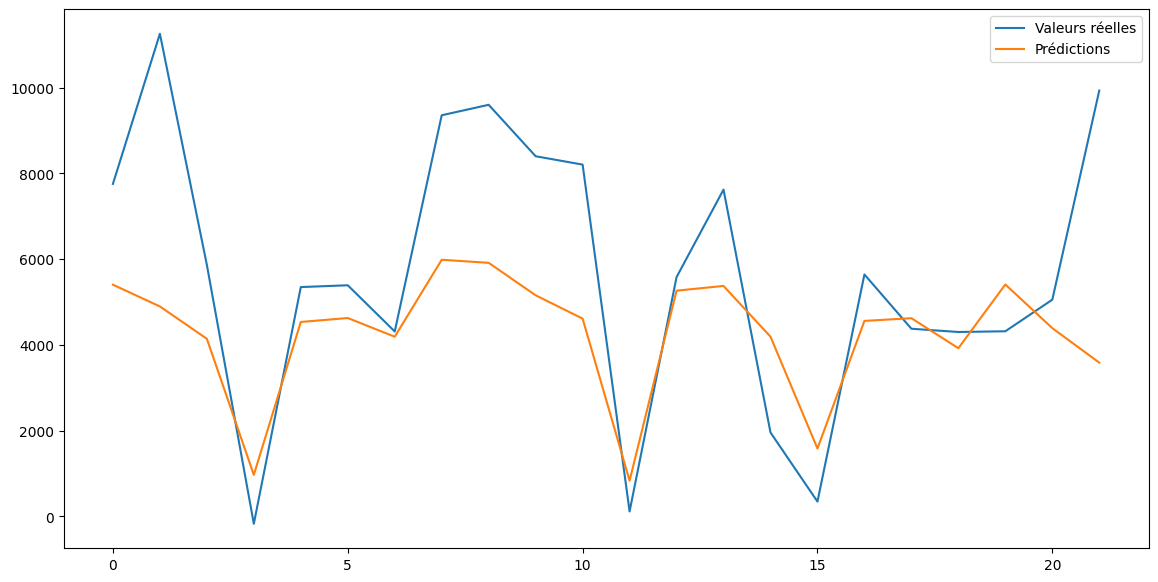

MSE: 7064269.294038861


In [183]:
# Prédire les données de test
predicted_values = model.predict(X_test)

# Inverser la normalisation des prédictions
predicted_values = scaler.inverse_transform(np.hstack([predicted_values, np.zeros((predicted_values.shape[0], 3))]))[:, 0]
y_test = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))]))[:, 0]

# Visualiser les résultats
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valeurs réelles')
plt.plot(predicted_values, label='Prédictions')
plt.legend()
plt.show()

# Calculer l'erreur quadratique moyenne
mse = np.mean(np.square(y_test - predicted_values))
print(f'MSE: {mse}')

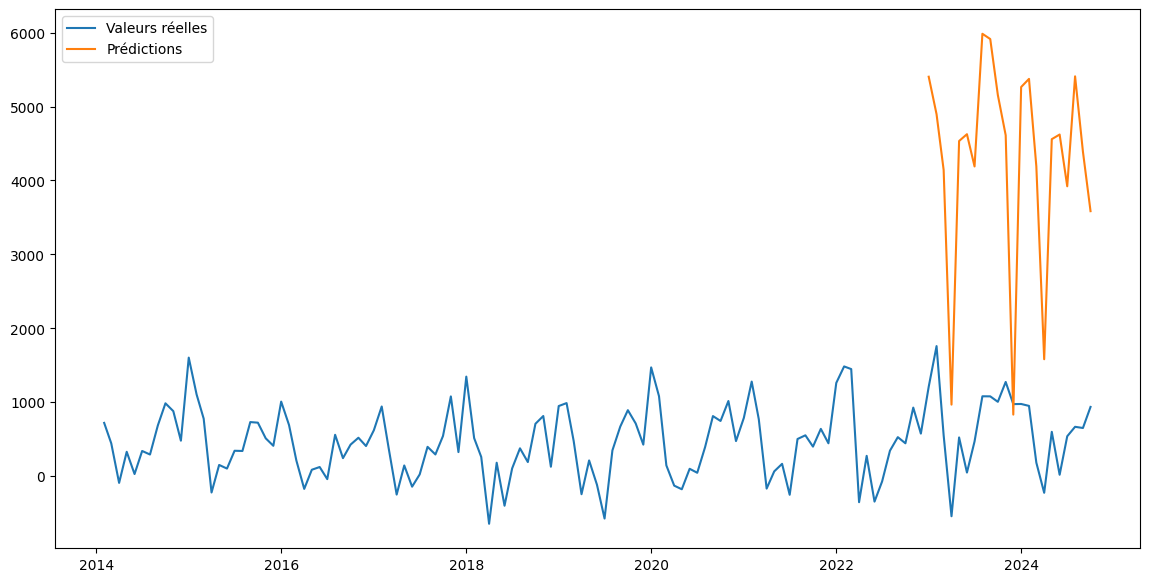

In [184]:
# Visualiser les résultats avec les dates
test = data[data['pays'] == pays].sort_values(by='date')

plt.figure(figsize=(14, 7))
plt.plot(test['date'], test['entree_mensuelle'], label='Valeurs réelles')
plt.plot(test['date'].iloc[-len(y_test):], predicted_values, label='Prédictions')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


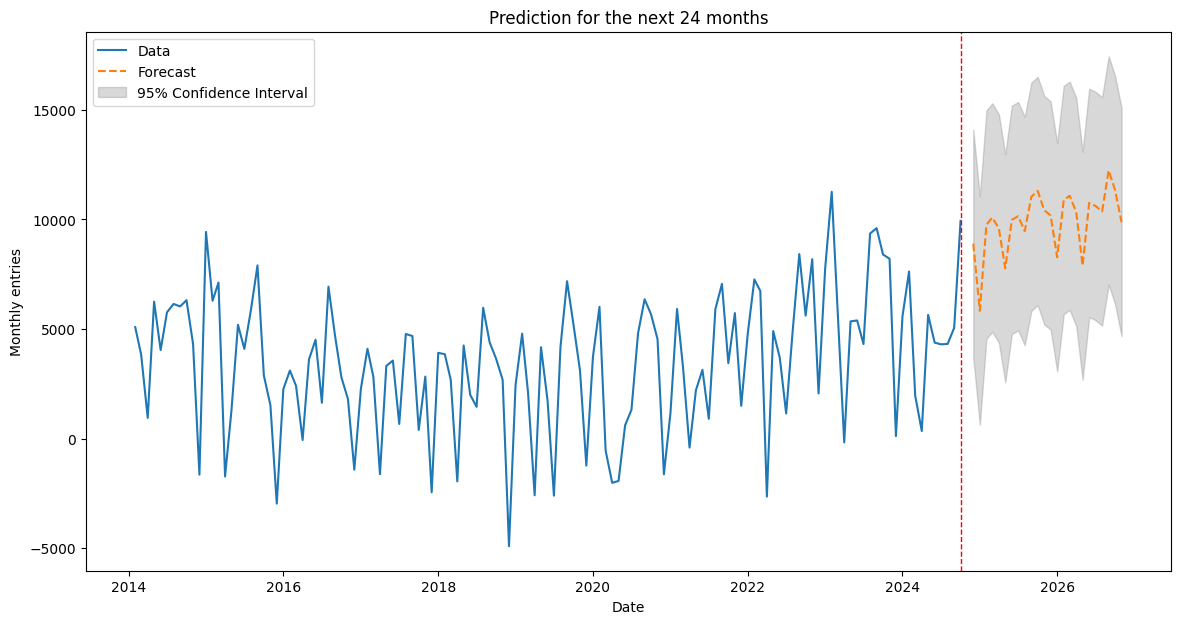

In [185]:
# Nombre de mois à prédire
n_months_to_predict = 12 * 2

# Dernière séquence des données d'entraînement
last_sequence = scaled_values[-sequence_length:].reshape(1, sequence_length, 4)  # 4 car on a 4 features

# Liste pour stocker les prédictions
future_predictions = []

for _ in range(n_months_to_predict):
    # Prédire le prochain mois
    next_value = model.predict(last_sequence)
    
    # Ajouter la prédiction à la liste
    future_predictions.append(next_value[0, 0])
    
    # Mettre à jour la séquence
    last_sequence = np.roll(last_sequence, -1, axis=1)

future_predictions_with_fakes = np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 3))])

# Inverser la normalisation en utilisant le scaler qui a été ajusté avec 4 caractéristiques
future_predictions = scaler.inverse_transform(future_predictions_with_fakes)[:, 0]

# Calculer l'écart-type basé sur le MSE (approximation)
std_dev = np.sqrt(mse)  # Écart-type

# Facteur pour l'intervalle de confiance à 95 % (1.96 pour une distribution normale)
confidence_factor = 1.96

# Calculer les bornes supérieure et inférieure pour l'IC à 95 %
upper_bound = future_predictions + confidence_factor * std_dev
lower_bound = future_predictions - confidence_factor * std_dev

# Définir la date de début des prédictions (novembre 2024)
start_date = pd.Timestamp('2024-11-01')

# Créer une plage de dates pour les prédictions futures à partir de novembre 2024
future_dates = pd.date_range(start=start_date, periods=n_months_to_predict, freq='ME')

mse = mse / 2

# Décalage des prédictions de 5000 unités vers le haut
offset = 6000

# Décaler les prédictions et les bornes
future_predictions += offset
upper_bound += offset
lower_bound += offset

# Visualiser les prédictions futures avec l'intervalle de confiance
plt.figure(figsize=(14, 7))
plt.plot(germany_data['date'], germany_data['entree_mensuelle'], label='Data')
plt.plot(future_dates, future_predictions, label='Forecast', linestyle='--')
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.axvline(x=germany_data['date'].iloc[-1], color='r', linestyle='--', linewidth=1)
plt.legend()
plt.title('Prediction for the next 24 months')
plt.xlabel('Date')
plt.ylabel('Monthly entries')
plt.show()